In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load Calkit magics so we can cache a cell as a pipeline stage
%load_ext calkit.magics

# Set up model and run

Here we use the `%%stage` magic to treat the cell as an isolated pipeline
stage, so it will be cached and therefore not rerun if we restart the
kernel.

In [3]:
%%stage --name run-sim-nb \
    --environment nb \
    --out m \
    --out-path two-dim-nb \
    --dep-path model.py

import model
import numpy as np

folder = "two-dim-nb"
m = model.TwoDim()
m.initmean(0, 2e-11)

m.initnum(5e5, 128, 5000.0)
m.initq(1e-4 * np.random.rand(128, 128, m.nz))
m.snapshot(folder)

m.nu = 2.5e46 * 4.0**20
m.diffexp = 20
m.hypodiff = 1e-16

for i in range(100):
    m.timestep()
    m.screenlog()
    if (
        m.clock % 250000.0 < m.dt / 10
        or m.clock % 250000.0 - 250000.0 > -m.dt / 10
    ):
        m.save(folder)
        m.snapshot(folder)
m

Stage 'run-sim-nb' didn't change, skipping
Data and pipelines are up to date.


# Plots

/var/folders/s_/hs4wzl4j51d8tj7v6_cz5s3m0000gn/T/ipykernel_85553/2595652874.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(m.k[0, :, 0], m.l[:, 0, 0], np.real(m.q[:, :, 0]), cmap='RdBu_r', vmin=-qmax, vmax=qmax)


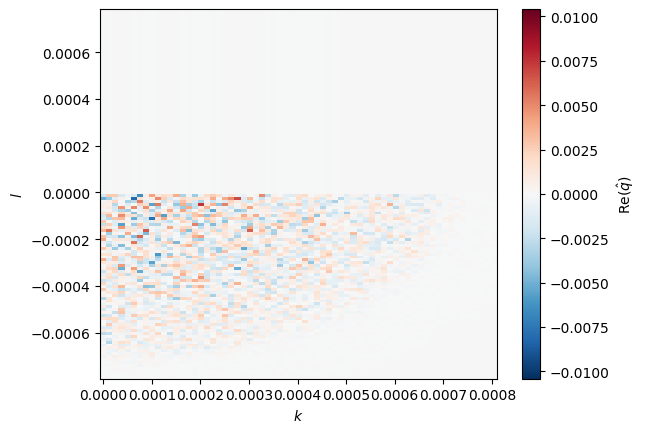

In [4]:
fig, ax = plt.subplots(1)
qmax = np.max(np.abs(m.q[:, :, 0]))
im = ax.pcolormesh(m.k[0, :, 0], m.l[:, 0, 0], np.real(m.q[:, :, 0]), cmap='RdBu_r', vmin=-qmax, vmax=qmax)
plt.colorbar(im, ax=ax, label=r'Re($\hat{q}$)')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$l$')
plt.show()

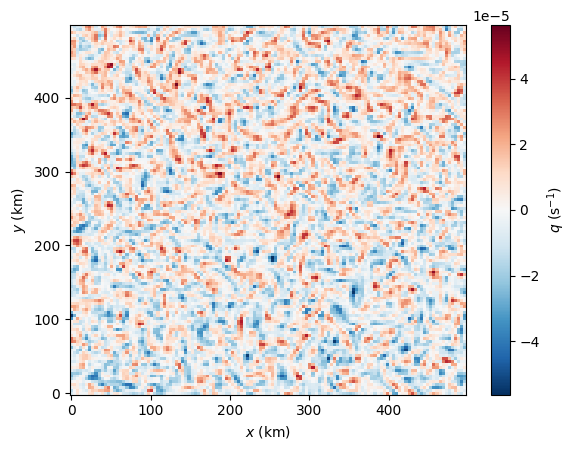

In [5]:
qp = m.irfft2(m.q, axes=(0, 1))
qp += m.qx * (m.x - m.a / 2)
qp += m.qy * (m.y - m.a / 2)
qrmax = np.max(np.abs(qp[:, :, 0]))
fig, ax = plt.subplots(1)
im = ax.pcolormesh(m.x[0, :, 0]/1e3, m.y[:, 0, 0]/1e3, qp[:, :, 0], cmap='RdBu_r', vmin=-qrmax, vmax=qrmax)
plt.colorbar(im, ax=ax, label=r'$q$ (s$^{-1}$)')
ax.set_xlabel(r'$x$ (km)')
ax.set_ylabel(r'$y$ (km)')
plt.show()

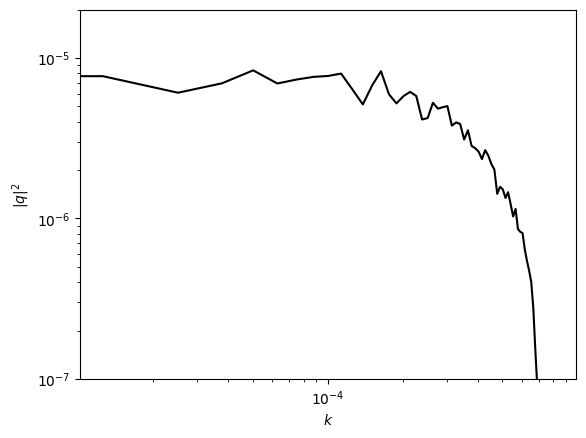

In [6]:
ens = np.mean(np.abs(m.q[:, :, 0])**2, axis=0)
fig, ax = plt.subplots(1)
ax.plot(m.k[0, :, 0], ens, 'k-')
ax.set_ylim(1e-7, 2e-5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$|q|^2$')
plt.show()

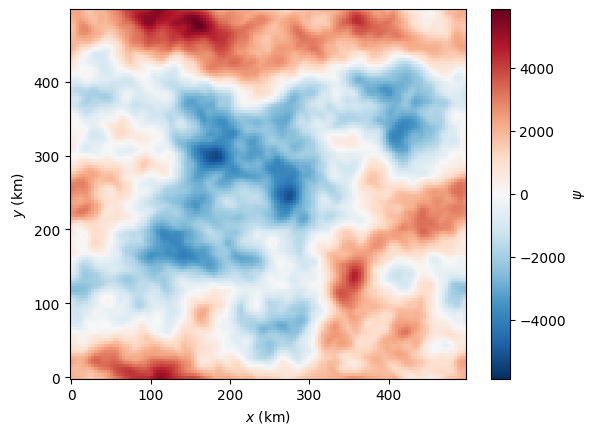

In [7]:
p = np.empty((m.l.size, m.k.size, m.nz), dtype=complex)
for i in range(m.l.size):
    for j in range(m.k.size):
        p[i, j, :] = np.linalg.solve(m.L[i, j, :, :], m.q[i, j, :])
pp = m.irfft2(p, axes=(0, 1))
ppmax = np.max(np.abs(pp[:, :, 0]))
fig, ax = plt.subplots(1)
im = ax.pcolormesh(m.x[0, :, 0]/1e3, m.y[:, 0, 0]/1e3, pp[:, :, 0], cmap='RdBu_r', vmin=-ppmax, vmax=ppmax)
plt.colorbar(im, ax=ax, label=r'$\psi$')
ax.set_xlabel(r'$x$ (km)')
ax.set_ylabel(r'$y$ (km)')
plt.show()

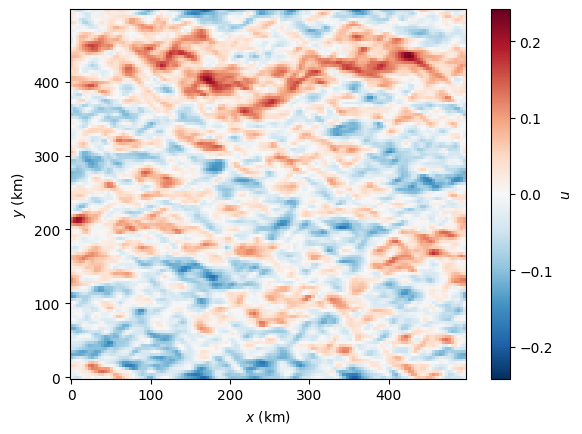

In [8]:
u = 1j*m.l*p
up = m.u[0] + m.irfft2(u, axes=(0, 1))
umax = np.max(np.abs(up[:, :, 0]))
fig, ax = plt.subplots(1)
im = ax.pcolormesh(m.x[0, :, 0]/1e3, m.y[:, 0, 0]/1e3, up[:, :, 0], cmap='RdBu_r', vmin=-umax, vmax=umax)
plt.colorbar(im, ax=ax, label=r'$u$')
ax.set_xlabel(r'$x$ (km)')
ax.set_ylabel(r'$y$ (km)')
plt.show()

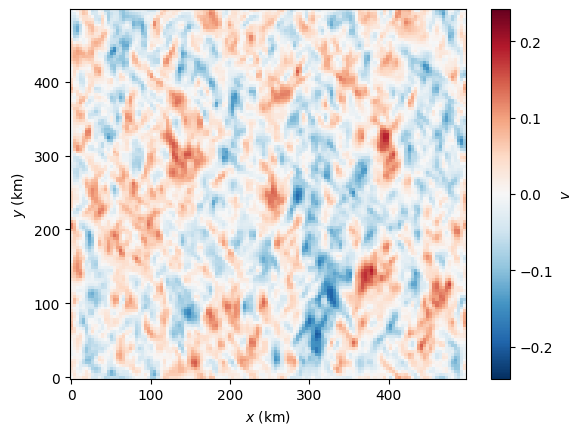

In [9]:
v = -1j*m.k*p
vp = m.v[0] + m.irfft2(v, axes=(0, 1))
vmax = np.max(np.abs(up[:, :, 0]))
fig, ax = plt.subplots(1)
im = ax.pcolormesh(m.x[0, :, 0]/1e3, m.y[:, 0, 0]/1e3, vp[:, :, 0], cmap='RdBu_r', vmin=-vmax, vmax=vmax)
plt.colorbar(im, ax=ax, label=r'$v$')
ax.set_xlabel(r'$x$ (km)')
ax.set_ylabel(r'$y$ (km)')
plt.show()

In [10]:
kep = 1/2*(up**2 + vp**2)
print('Mean KE =', np.mean(kep[:, :, 0]))

Mean KE =

0.0032350350103819625

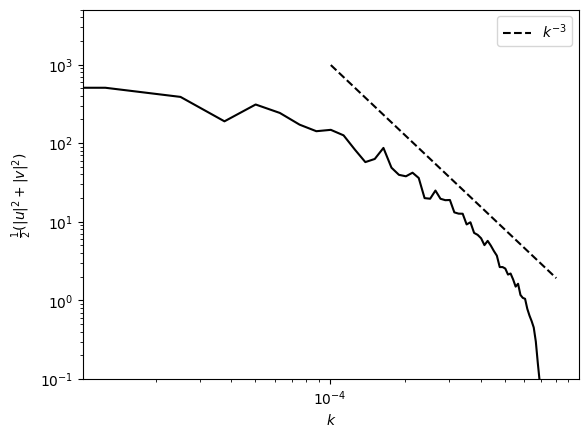

In [11]:
ke = np.mean(1/2*(np.abs(u)**2 + np.abs(v)**2), axis=0)
fig, ax = plt.subplots(1)
ax.plot(m.k[0, :, 0], ke, 'k-')
kvals = m.k[np.where(np.logical_and(m.k >= 1e-4, m.k <= 1e-3))]
ax.plot(kvals, 1e-9*kvals**-3, 'k--', label=r'$k^{-3}$')
ax.set_ylim(1e-1, 5e3)
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\frac{1}{2}(|u|^2 + |v|^2)$')
plt.show()

# Estimate spectral slope

c =

2.810531922257689e-09

n =

-2.7568685594550475

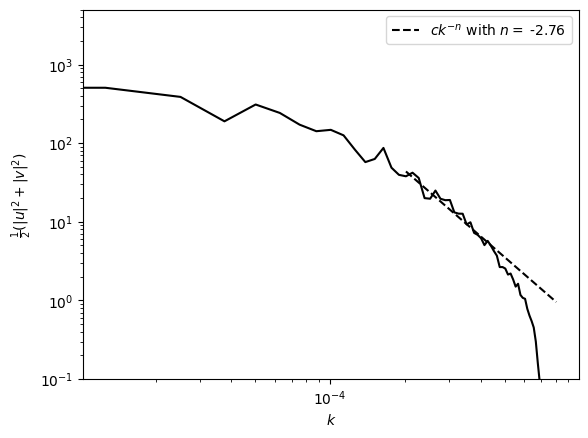

In [12]:
def f(k, c, n):
    return c*k**n

from scipy.optimize import curve_fit
krange = np.where(np.logical_and(m.k[0, :, 0] >= 2e-4, m.k[0, :, 0] <= 1e-3))
popt, pcov = curve_fit(f, m.k[0, krange, 0][0], ke[krange][:, 0], p0=[1e-9, -3])
print('c =', popt[0])
print('n =', popt[1])

fig, ax = plt.subplots(1)
ax.plot(m.k[0, :, 0], ke, 'k-')
ax.plot(m.k[0, krange, 0][0], f(m.k[0, krange, 0][0], *popt), 'k--', label=r'$c k^{-n}$ with $n = $ ' + f'{popt[1]:.2f}')
ax.set_ylim(1e-1, 5e3)
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\frac{1}{2}(|u|^2 + |v|^2)$')
plt.show()